# Fear lesson number 2
This lesson has a PV and PN cell with both with background and tone input

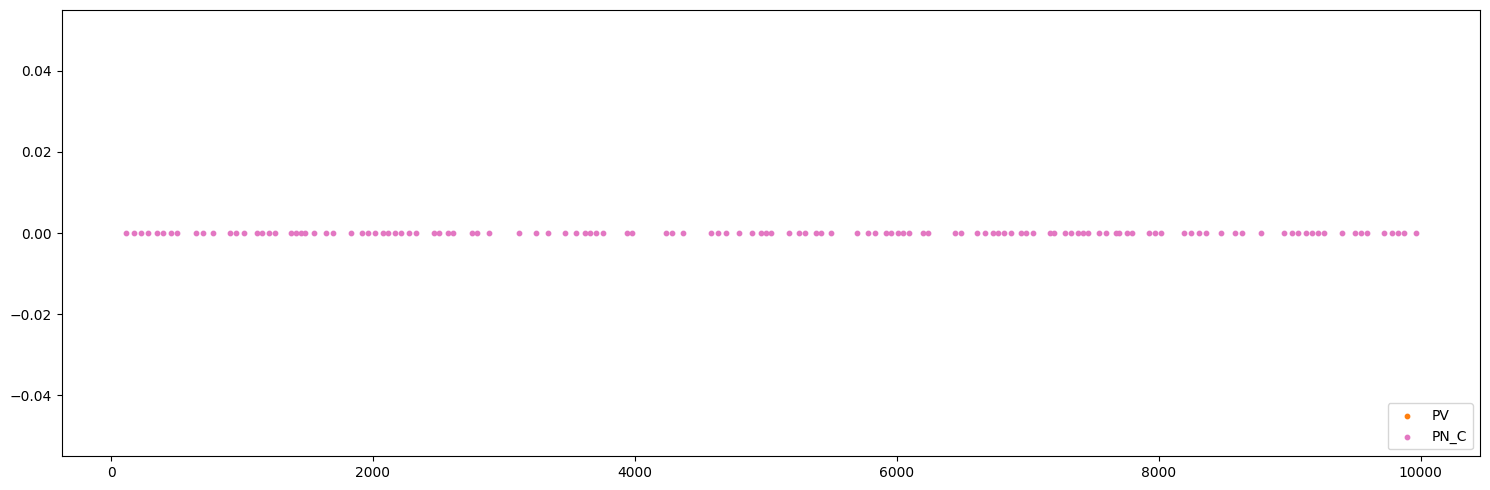

In [1]:
#@title Run cell to activate model

import os, sys
from io import StringIO
RunningInCOLAB = 'google.colab' in str(get_ipython())

print("Trying to downloading model this will only take a min!")
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
  if RunningInCOLAB:
      print('Downloading packages')
      !pip install NEURON
      !pip install bmtk
      !pip install ipywidgets==7.7.1

  if os.path.basename(os.getcwd())!='D2':
      !git clone https://github.com/GregGlickert/Fear-Lesson-Plans.git
      %cd Fear-Lesson-Plans/D2/biophys_components/mechanisms/
      !nrnivmodl modfiles
      %cd ../..
      %ls
      print("model was downloaded!")
  else:
    try: #assuming your already in the 2 cell folder like on ur local machine
      %cd biophys_components/mechanisms/
      !nrnivmodl modfiles
      %cd ../..
      %ls
    except:
      pass
  print("model was compiled!")


from bmtk.builder import NetworkBuilder
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from bmtk.utils.sim_setup import build_env_bionet
import numpy as np
import sys
import os
import random
import shutil
import warnings
import synapses
from matplotlib import gridspec

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

if os.path.isdir('network'):
    shutil.rmtree('network')

seed = 967
random.seed(seed)
np.random.seed(seed)
synapses.load()
syn = synapses.syn_params_dicts()

# Initialize our network

net = NetworkBuilder("biophysical")

num_inh = [1]

num_exc = [1]

##################################################################################
###################################BIOPHY#########################################

#PN
net.add_nodes(N=1, pop_name='PyrC',
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:Cell_C',
              morphology=None)

#PV
net.add_nodes(N=1, pop_name="PV",
              mem_potential='e',
              model_type='biophysical',
              model_template='hoc:basket',
              morphology=None
              )

tone = NetworkBuilder('tone')
tone.add_nodes(N=1,
               pop_name='tone',
               potential='exc',
               model_type='virtual')

# External inhibitory inputs
shock = NetworkBuilder('shock')
shock.add_nodes(N=1,
                pop_name='shock',
                potential='exc',
                model_type='virtual')

backgroundPN_C = NetworkBuilder('bg_pn_c')
backgroundPN_C.add_nodes(N=1,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')

backgroundPV = NetworkBuilder('bg_pv')
backgroundPV.add_nodes(N=2,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')


#if neuron is sufficiently depolorized enough post synaptic calcium then synaptiic weight goes up

#pyr->pyr & pyr->PV
#PV->pyr PV->PV
def one_to_all(source, target):
    sid = source.node_id
    tid = target.node_id
    #print("connecting bio cell {} to bio cell {}".format(sid, tid))
    return 1

def BG_to_PN_C(source, target):
    sid = source.node_id
    tid = target.node_id
    if sid == tid:
        #print("connecting BG {} to PN_C{}".format(sid,tid))
        return 1
    else:
        return 0

def BG_to_PV(source, target):
    sid = source.node_id
    tid = target.node_id
    sid = sid + 1
    if sid == tid:
        #print("connecting BG {} to PV{}".format(sid,tid))
        return 1
    else:
        return 0


#conn = net.add_edges(source=shock.nodes(), target=net.nodes(pop_name='PV'),
#              connection_rule=1,
#              syn_weight=1.0,
#              target_sections=['basal'],
#              delay=0.1,
#              distance_range=[-10000, 10000],
#              dynamics_params='shock2INT12.json',
#              model_template=syn['shock2INT12.json']['level_of_detail'])

conn = net.add_edges(source=tone.nodes(), target=net.nodes(pop_name=['PyrC']),
              connection_rule=1,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='tone2PN.json',
              model_template=syn['tone2PN.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float64]) # places syn on apic at 0.9

conn = net.add_edges(source=tone.nodes(), target=net.nodes(pop_name='PV'),
              connection_rule=1,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='tone2INT.json',
              model_template=syn['tone2INT.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float64]) # places syn on basal at 0.9

conn = net.add_edges(source=net.nodes(pop_name='PyrC'), target=net.nodes(pop_name="PV"),
              connection_rule=one_to_all,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PN2PV.json',
              model_template=syn['PN2PV.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float64])

conn = net.add_edges(source=net.nodes(pop_name='PV'), target=net.nodes(pop_name="PyrC"),
              connection_rule=10,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='PV2PN.json',
              model_template=syn['PV2PN.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float64])

conn = net.add_edges(source=backgroundPN_C.nodes(), target=net.nodes(pop_name='PyrC'),
              connection_rule=BG_to_PN_C,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2PNC.json',
              model_template=syn['BG2PNC.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(2, 0.9), dtypes=[np.int32, np.float64]) # places syn on apic at 0.9

conn = net.add_edges(source=backgroundPV.nodes(), target=net.nodes(pop_name='PV'),
              connection_rule=BG_to_PV,
              syn_weight=1.0,
              delay=0.1,
              distance_range=[-10000, 10000],
              dynamics_params='BG2PV.json',
              model_template=syn['BG2PV.json']['level_of_detail'])
conn.add_properties(['sec_id', 'sec_x'], rule=(1, 0.9), dtypes=[np.int32, np.float64])




net.build()
net.save(output_dir='network')

tone.build()
tone.save_nodes(output_dir='network')

backgroundPN_C.build()
backgroundPN_C.save_nodes(output_dir='network')

backgroundPV.build()
backgroundPV.save_nodes(output_dir='network')


#SPIKE TRAINS
t_sim = 10000

build_env_bionet(base_dir='./',
                 network_dir='./network',
                 tstop=t_sim, dt=0.1,
                 report_vars=['v'],
                 components_dir='biophys_components',
                 config_file='config.json',
                 spikes_inputs=[('bg_pn_c', '2_cell_inputs/bg_pn_c_spikes.h5'),
                                ('bg_pv', '2_cell_inputs/bg_pv_spikes.h5'),
                                ('tone', '2_cell_inputs/tones.h5')],
                 compile_mechanisms=False,
                 overwrite_config=True)

psg = PoissonSpikeGenerator(population='bg_pn_c')
psg.add(node_ids=range(1),  # need same number as cells
        firing_rate=6,    # 1 spike every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('2_cell_inputs/bg_pn_c_spikes.h5')

#print('Number of background spikes for PN_C: {}'.format(psg.n_spikes()))

psg = PoissonSpikeGenerator(population='bg_pv')
psg.add(node_ids=range(1),  # need same number as cells
        firing_rate=8,    # 8 spikes every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('2_cell_inputs/bg_pv_spikes.h5')

psg = PoissonSpikeGenerator(population='tone')
psg.add(node_ids=range(1),  # need same number as cells
        firing_rate=2,    # 8 spikes every 1 second Hz
        times=(0.0, t_sim/1000))  # time is in seconds for some reason
psg.to_sonata('2_cell_inputs/tones.h5')

#print('Number of background spikes for PV: {}'.format(psg.n_spikes()))

from ipywidgets import widgets, HBox, VBox
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
from IPython.display import clear_output
from IPython.utils import io
import os, sys
import json
from bmtk.simulator import bionet
import numpy as np
import warnings
import random
from io import StringIO
from neuron import h
import matplotlib.pyplot as plt
from bmtk.analyzer.compartment import plot_traces
import h5py
import pandas as pd
%matplotlib inline

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

tone_slider = widgets.IntSlider(value=2, min=1, max=20, step=1,description="Tone Hz")
#Create your button.
tone_button = widgets.Button(description="Generate")
tone_output = widgets.Output()

slider1 = widgets.IntSlider(value=6, min=1, max=20, step=1,description="PN_BACK")
#Create your button.
button1 = widgets.Button(description="Generate")
output1 = widgets.Output()

slider2 = widgets.IntSlider(value=8, min=1, max=20, step=1,description="PV_BACK")
#Create your button.
button2 = widgets.Button(description="Generate")
output2 = widgets.Output()
button3 = widgets.Button(description="run_model",icon='history',button_style='primary')

slider4 = widgets.IntSlider(value=1, min=1, max=20, step=1,description="PN2PV")
#Create your button.
button4 = widgets.Button(description="Edit")
output4 = widgets.Output()

slider5 = widgets.IntSlider(value=10, min=1, max=20, step=1,description="PV2PN")
#Create your button.
button5 = widgets.Button(description="Edit")
output5 = widgets.Output()

slider6 = widgets.IntSlider(value=1, min=1, max=20, step=1,description="TONE2PN")
#Create your button.
button6 = widgets.Button(description="Edit")
output6 = widgets.Output()

slider7 = widgets.IntSlider(value=5, min=1, max=20, step=1,description="TONE2PV")
#Create your button.
button7 = widgets.Button(description="Edit")
output7 = widgets.Output()

slider8 = widgets.FloatSlider(value=0.2, min=0, max=0.5, step=0.01,description="Threshold1")
#Create your button.
button8 = widgets.Button(description="Edit")
output8 = widgets.Output()

slider9 = widgets.FloatSlider(value=0.3, min=0, max=0.5, step=0.01,description="Threshold2")
#Create your button.
button9 = widgets.Button(description="Edit")
output9 = widgets.Output()

slider10 = widgets.FloatSlider(value=10000, min=100, max=30000, step=1000,description="Tsim")
#Create your button.
button10 = widgets.Button(description="Edit")
output10 = widgets.Output()



#function to handle input.
def gen_bg_pn(btn):
    clear_output()
    output1.clear_output()
    return_value = slider1.value
    os.remove('2_cell_inputs/bg_pn_c_spikes.h5')
    psg = PoissonSpikeGenerator(population='bg_pn_c')
    psg.add(node_ids=range(1),  # need same number as cells
        firing_rate=return_value,    # 1 spike every 1 second Hz
        times=(0.0, 40000/1000))  # time is in seconds for some reason
    psg.to_sonata('2_cell_inputs/bg_pn_c_spikes.h5')
    print('Generated background of PN at : {} Hz'.format(return_value))
    #with output1:
        #print(return_value)
    display(ui)
def gen_bg_pv(btn):
    clear_output()
    output2.clear_output()
    return_value = slider2.value
    os.remove('2_cell_inputs/bg_pv_spikes.h5')
    psg = PoissonSpikeGenerator(population='bg_pv')
    psg.add(node_ids=range(1),  # need same number as cells
        firing_rate=return_value,    # 1 spike every 1 second Hz
        times=(0.0, 40000/1000))  # time is in seconds for some reason
    psg.to_sonata('2_cell_inputs/bg_pv_spikes.h5')
    print('Generated background of PV at : {} Hz'.format(return_value))
    display(ui)

def gen_tone(btn):
    clear_output()
    tone_output.clear_output()
    return_value = tone_slider.value
    os.remove('2_cell_inputs/tones.h5')
    psg = PoissonSpikeGenerator(population='tone')
    psg.add(node_ids=range(1),  # need same number as cells
        firing_rate=return_value,    # 1 spike every 1 second Hz
        times=(0.0, 40000/1000))  # time is in seconds for some reason
    psg.to_sonata('2_cell_inputs/tones.h5')
    print('Generated tone Hz of : {} Hz'.format(return_value))
    display(ui)

def change_PN2PV(btn):
    clear_output()
    output4.clear_output()
    return_value = slider4.value
    with open('biophys_components/synaptic_models/PN2PV.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed PN2PV synaptic weight to {}".format(return_value))
    display(ui)


def change_PV2PN(btn):
    clear_output()
    output5.clear_output()
    return_value = slider5.value
    with open('biophys_components/synaptic_models/PV2PN.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = (return_value*15) # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed PV2PN synaptic weight to {}".format(return_value))
    display(ui)

def change_TONE2PN(btn):
    clear_output()
    output6.clear_output()
    return_value = slider6.value
    with open('biophys_components/synaptic_models/tone2PN.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed TONE2PN synaptic weight to {}".format(return_value))
    display(ui)

def change_threshold1(btn):
    clear_output()
    output8.clear_output()
    return_value = slider8.value
    with open('biophys_components/synaptic_models/tone2PN.json', 'r+') as f:
        data = json.load(f)
        data['threshold1'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed threshold1 to {}".format(return_value))
    display(ui)

def change_threshold2(btn):
    clear_output()
    output9.clear_output()
    return_value = slider9.value
    with open('biophys_components/synaptic_models/tone2PN.json', 'r+') as f:
        data = json.load(f)
        data['threshold2'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed threshold2 to {}".format(return_value))
    display(ui)

def change_TONE2PV(btn):
    clear_output()
    output7.clear_output()
    return_value = slider7.value
    with open('biophys_components/synaptic_models/tone2INT.json', 'r+') as f:
        data = json.load(f)
        data['initW'] = return_value # <--- edit `initW` value.
        f.seek(0)        # <--- should reset file position to the beginning.
        json.dump(data, f, indent=4)
        f.truncate()     # remove remaining part
        print("Changed TONE2PV synaptic weight to {}".format(return_value))
    display(ui)

def change_shock(btn):
    clear_output()
    output10.clear_output()
    return_value = slider10.value
    build_env_bionet(base_dir='./',
                 network_dir='./network',
                 tstop=return_value, dt=0.1,
                 report_vars=['v'],
                 components_dir='biophys_components',
                 config_file='config.json',
                 spikes_inputs=[('bg_pn_c', '2_cell_inputs/bg_pn_c_spikes.h5'),
                                ('bg_pv', '2_cell_inputs/bg_pv_spikes.h5')],
                 compile_mechanisms=False,
                 overwrite_config=True)
    display(ui)

button1.on_click(gen_bg_pn)
button2.on_click(gen_bg_pv)
button4.on_click(change_PN2PV)
button5.on_click(change_PV2PN)
button6.on_click(change_TONE2PN)
button7.on_click(change_TONE2PV)
button8.on_click(change_threshold1)
button9.on_click(change_threshold2)
button10.on_click(change_shock)
tone_button.on_click(gen_tone)

def plot_output():
  fig = plt.figure(figsize=(15, 5),tight_layout=True)
  gs = gridspec.GridSpec(1, 1, width_ratios=[1],height_ratios=[1])
  #ax0 = plt.subplot(gs[0,0])
  ax1 = plt.subplot(gs[0,0])
  #ax2 = plt.subplot(gs[1,0])
  #ax3 = plt.subplot(gs[1,1])

  def spike_frequency_bar_graph(spikes_df, node_set, ms, start=0, end=80000, ax=None, n_bins=10):
      mean = []
      name = []
      labels = []
      for node in node_set:
          cells = range(node['start'], node['end'] + 1)  # +1 to be inclusive of last cell
          cell_spikes = spikes_df[spikes_df['node_ids'].isin(cells)]

          # skip the first few ms
          cell_spikes = cell_spikes[cell_spikes['timestamps'] > start]
          cell_spikes = cell_spikes[cell_spikes['timestamps'] < end]
          spike_counts = cell_spikes.node_ids.value_counts()
          total_seconds = (ms) / 1000
          spike_counts_per_second = spike_counts / total_seconds

          spikes_mean = spike_counts_per_second.mean()
          spikes_std = spike_counts_per_second.std()

          label = "{} : {:.2f} ({:.2f})".format(node['name'], spikes_mean, spikes_std)
          #print(label)
          c = "tab:" + node['color']
          if ax:
              mean.append(spikes_mean)
              name.append(node['name'])
              labels.append(label)
              ax.bar(node['name'], spikes_mean,label=label,color=c)


      if ax:
          ax.legend()

  def raster(spikes_df, node_set, start=0,end=80000, ax=None):
    spikes_df = spikes_df[spikes_df['timestamps'] > start]
    spikes_df = spikes_df[spikes_df['timestamps'] < end]
    for node in node_set:
        cells = range(node['start'], node['end'] + 1)  # +1 to be inclusive of last cell
        cell_spikes = spikes_df[spikes_df['node_ids'].isin(cells)]

        ax.scatter(cell_spikes['timestamps'], cell_spikes['node_ids'],
                   c='tab:' + node['color'], s=10, label=node['name'])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels),loc='lower right')
    ax.grid(False)
  try:
    f = h5py.File('output/spikes.h5','r')
    spikes_df = pd.DataFrame({'node_ids':f['spikes']['biophysical']['node_ids'],'timestamps':f['spikes']['biophysical']['timestamps']})
    node_set = [
          {"name": "PN_C", "start": 0, "end": 0, "color": "pink"},
          {"name": "PV", "start": 1, "end": 1, "color": "orange"}
      ]
    start1 = 0
    end1 = 10000
    #spike_frequency_bar_graph(spikes_df,node_set,start=start1,end=end1,ax=ax0,ms=(end1-start1))
    raster(spikes_df, node_set, start=start1, end=end1, ax=ax1)
  except:
    print("NO SPIKES FOUND")


  def get_array(path):
      try:
          array = h5py.File(path,'r')
          array = (array['report']['biophysical']['data'][:])
      except:
          pass
      return array

  #tone2pyr = get_array('output/syns_cai.h5')
  #tone2pyr[:] = [x * 1000 for x in tone2pyr]
  #ax2.plot(tone2pyr)
  #ax2.set_title("tone2pyr cai")
  #ax2.set_xlabel('time')
  #ax2.set_ylabel('cai (uM)')

  #tone2pyr = get_array('output/syns_tone2pyr.h5')
  #ax3.plot(tone2pyr)
  #ax3.set_title("tone2pyr weight")
  #ax3.set_xlabel('time')
  #ax3.set_ylabel('Weight')

  plt.show()

def run_model(*args):
    clear_output()
    with Capturing() as output:
        synapses.load()
        h.nrnmpi_init()
        pc = h.ParallelContext()  # object to access MPI methods
        MPI_size = int(pc.nhost())
        MPI_rank = int(pc.id())


        config_file = 'config.json'



        conf = bionet.Config.from_json(config_file, validate=True);
        conf.build_env();

        graph = bionet.BioNetwork.from_config(conf);
        sim = bionet.BioSimulator.from_config(conf, network=graph);

        cells = graph.get_local_cells();

        sim.run();

        pc.barrier();
        pc.gid_clear()
        pc.done()
    clear_output()
    plot_output()
    display(ui)
button3.on_click(run_model)





ui = VBox([ HBox([slider1, button1, slider2,button2,slider6,button6]),HBox([slider4,button4,slider5,button5,slider7,button7]),
           HBox([slider10,button10,tone_slider,tone_button])
           ,button3])
ui


